So this one involves a bit of manual tweaking after the fact, but I also want to update this to have only hmmer hits, so it should make it less blue.
# Libraries

In [1]:
import pandas as pd
import numpy as np

%load_ext rpy2.ipython

In [2]:
%%R

library(tidyverse)
library(ape)
library(readxl)
library(ggtree)
library(treeio)
library(svglite)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

R[write to console]: ggtree v3.4.0 For help: https://yulab-smu.top/treedata-book/

If you use the ggtree package suite in published research, please cite
the appropriate paper(s):

Guangchuang Yu, David Smith, Huachen Zhu, Yi Guan, Tommy Tsan-Yuk Lam.
ggtree: an R package for visualization and annotation of phylogenetic
trees with their covariates and other associated data. Methods in
Ecology and Evolution. 2017, 8(1):28-36. doi:10.1111/2041-210X.12628

S Xu, Z Dai, P Guo, X Fu, S Liu, L Zhou, W Tang, T Feng, M Chen, L
Zhan, T Wu, E Hu, Y Jiang,

# Data

In [3]:
%%R
gtdb_tree <- read.tree("data/bac120_7.7.22.tree")

In [4]:
%%R
assemblies <- read_excel("data/Enterobacterales_assembly_summary.xlsx", sheet = "Enterobacterales") %>%
	separate(`NCBI Organism Name`,c("g","s")) %>%
	unite("specific_epithet",c("g","s"))


In [5]:
%%R
samples <- read.table("data/Enterobacteriales_samples.txt", header = FALSE) %>%
	as.tibble() %>%
	rename(path = V1)
samples

# A tibble: 5,142 × 1
   path                                                                         
   <chr>                                                                        
 1 genomes/Enterobacterales/alnajar2017phylogenomics/Enterobacteriaceae_gtdb/ot…
 2 genomes/Enterobacterales/alnajar2017phylogenomics/Enterobacteriaceae_gtdb/ot…
 3 genomes/Enterobacterales/alnajar2017phylogenomics/Enterobacteriaceae_gtdb/ot…
 4 genomes/Enterobacterales/alnajar2017phylogenomics/Enterobacteriaceae_gtdb/ot…
 5 genomes/Enterobacterales/alnajar2017phylogenomics/Enterobacteriaceae_gtdb/ot…
 6 genomes/Enterobacterales/alnajar2017phylogenomics/Enterobacteriaceae_gtdb/ot…
 7 genomes/Enterobacterales/alnajar2017phylogenomics/Enterobacteriaceae_gtdb/ot…
 8 genomes/Enterobacterales/alnajar2017phylogenomics/Enterobacteriaceae_gtdb/ot…
 9 genomes/Enterobacterales/alnajar2017phylogenomics/Enterobacteriaceae_gtdb/ot…
10 genomes/Enterobacterales/alnajar2017phylogenomics/Enterobacteriaceae_gtdb/ot…
# … wi

In [6]:
%%R
all_best_hits <- read_csv("data/Enterobacteriales_all_best_hits.csv")

Rows: 16524 Columns: 25
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (8): qseqid, sseqid, component, cinful_id, pephash, sample, contig, seq
dbl (13): pident, length, mismatch, gapopen, qstart, qend, sstart, send, eva...
lgl  (4): hmmerHit, verified, allStandardAA, signalMatch

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
%%R 
samples %>%
separate(path, c(NA,NA,NA,"f4"), sep = "/") %>%
	count(f4)

# A tibble: 4 × 2
  f4                          n
  <chr>                   <int>
1 Enterobacteriaceae_gtdb  4859
2 Pasteurellaceae_gtdb       68
3 refseq                     72
4 Vibrionaceae_gtdb         143


In [8]:
%%R 
outgroup_samples <- samples %>%
	separate(path, c(NA,NA,NA,"family_name",NA,NA,"ID"), sep = "/") %>%
	filter(family_name %in% c("Pasteurellaceae_gtdb","Vibrionaceae_gtdb")) %>% 
	mutate(family_name = str_replace_all(family_name, "_gtdb",""))
	# count(family_name)
outgroup_samples

# A tibble: 211 × 2
   family_name     ID             
   <chr>           <chr>          
 1 Pasteurellaceae GCF_000379785.1
 2 Pasteurellaceae GCF_901764995.1
 3 Pasteurellaceae GCF_013377275.1
 4 Pasteurellaceae GCF_011455495.1
 5 Pasteurellaceae GCF_002015035.1
 6 Pasteurellaceae GCF_900186835.1
 7 Pasteurellaceae GCF_014202395.1
 8 Pasteurellaceae GCF_011455875.1
 9 Pasteurellaceae GCF_000188255.1
10 Pasteurellaceae GCF_900450705.1
# … with 201 more rows


In [9]:
%%R
other_family_samples <- samples %>%
	separate(path, c(NA,NA,NA,"f4","f5","family_name",NA,NA,"ID"), sep = "/") %>% 
		filter(f4 == "Enterobacteriaceae_gtdb") %>%
		filter(f5 == "other_families") %>%
		select(family_name, ID)
other_family_samples

# A tibble: 85 × 2
   family_name       ID             
   <chr>             <chr>          
 1 Pectobacteriaceae GCF_000406145.1
 2 Pectobacteriaceae GCF_002291445.1
 3 Pectobacteriaceae GCF_000365305.1
 4 Pectobacteriaceae GCF_001644705.1
 5 Pectobacteriaceae GCF_001038685.1
 6 Pectobacteriaceae GCF_000406165.1
 7 Pectobacteriaceae GCF_000688655.1
 8 Pectobacteriaceae GCF_000400505.1
 9 Pectobacteriaceae GCF_900129615.1
10 Pectobacteriaceae GCF_000406105.1
# … with 75 more rows


In [10]:
%%R 
Enterobacterales_samples <- other_family_samples %>%
	full_join(outgroup_samples)
Enterobacterales_samples

Joining, by = c("family_name", "ID")
# A tibble: 296 × 2
   family_name       ID             
   <chr>             <chr>          
 1 Pectobacteriaceae GCF_000406145.1
 2 Pectobacteriaceae GCF_002291445.1
 3 Pectobacteriaceae GCF_000365305.1
 4 Pectobacteriaceae GCF_001644705.1
 5 Pectobacteriaceae GCF_001038685.1
 6 Pectobacteriaceae GCF_000406165.1
 7 Pectobacteriaceae GCF_000688655.1
 8 Pectobacteriaceae GCF_000400505.1
 9 Pectobacteriaceae GCF_900129615.1
10 Pectobacteriaceae GCF_000406105.1
# … with 286 more rows


In [11]:
%%R
Enterobacterales_samples %>% 
	count(family_name)

# A tibble: 8 × 2
  family_name           n
  <chr>             <int>
1 Budviciaceae          3
2 Erwiniaceae          20
3 Hafniaceae            8
4 Morganellaceae       15
5 Pasteurellaceae      68
6 Pectobacteriaceae    12
7 Vibrionaceae        143
8 Yersiniaceae         27


In [12]:
%%R
write_csv(Enterobacterales_samples,'data/supplemental/Enterobacterales_genome_samples.csv')

In [13]:
%%R
assemblies_sp_ID <- assemblies %>%
	right_join(Enterobacterales_samples) 
	# filter(ID %in% all_samples$ID) #%>%
	# count(family_name)
assemblies_sp_ID

Joining, by = "ID"
# A tibble: 296 × 14
   ID          specific_epithet `NCBI Taxonomy` `GTDB Taxonomy` `GTDB species …`
   <chr>       <chr>            <chr>           <chr>           <chr>           
 1 GCF_000026… Erwinia_tasmani… d__Bacteria; p… d__Bacteria; p… yes             
 2 GCF_000026… Erwinia_pyrifol… d__Bacteria; p… d__Bacteria; p… yes             
 3 GCF_000156… Providencia_rus… d__Bacteria; p… d__Bacteria; p… yes             
 4 GCF_000160… Proteus_mirabil… d__Bacteria; p… d__Bacteria; p… yes             
 5 GCF_000165… Vibrio_caribbea… d__Bacteria; p… d__Bacteria; p… yes             
 6 GCF_000173… Providencia_alc… d__Bacteria; p… d__Bacteria; p… yes             
 7 GCF_000173… Yersinia_aldovae d__Bacteria; p… d__Bacteria; p… yes             
 8 GCF_000173… Yersinia_rohdei  d__Bacteria; p… d__Bacteria; p… yes             
 9 GCF_000175… Actinobacillus_… d__Bacteria; p… d__Bacteria; p… yes             
10 GCF_000176… Vibrio_corallii… d__Bacteria; p… d__Bacteria; p… yes  

In [14]:
%%R
assemblies_sp_ID %>%
	count(family_name)

# A tibble: 8 × 2
  family_name           n
  <chr>             <int>
1 Budviciaceae          3
2 Erwiniaceae          20
3 Hafniaceae            8
4 Morganellaceae       15
5 Pasteurellaceae      68
6 Pectobacteriaceae    12
7 Vibrionaceae        143
8 Yersiniaceae         27


In [15]:
%%R 
gtdb_tree_ID <- gtdb_tree$tip.label %>%
	as.tibble() %>%
	separate(value, c(NA, "a","b"), remove = FALSE, sep = "_") %>%
	unite("ID", c(a,b)) %>%
	mutate(ID = str_replace_all(ID, "'","")) %>%
	filter(ID %in% assemblies_sp_ID$ID)
gtdb_tree_ID

# A tibble: 291 × 2
   value              ID             
   <chr>              <chr>          
 1 RS_GCF_002216855.1 GCF_002216855.1
 2 RS_GCF_900115495.1 GCF_900115495.1
 3 RS_GCF_004120195.1 GCF_004120195.1
 4 RS_GCF_000621165.1 GCF_000621165.1
 5 RS_GCF_900167155.1 GCF_900167155.1
 6 RS_GCF_001559595.1 GCF_001559595.1
 7 RS_GCF_900055185.1 GCF_900055185.1
 8 RS_GCF_900060185.1 GCF_900060185.1
 9 RS_GCF_000333895.2 GCF_000333895.2
10 RS_GCF_001996165.1 GCF_001996165.1
# … with 281 more rows


In [16]:
%%R
gtdb_tree$tip.label %>%
	as.tibble() 

# A tibble: 62,291 × 1
   value             
   <chr>             
 1 GB_GCA_001829155.1
 2 GB_GCA_002450905.1
 3 GB_GCA_003645695.1
 4 GB_GCA_016934265.1
 5 GB_GCA_011049595.1
 6 GB_GCA_012517545.1
 7 GB_GCA_012797605.1
 8 GB_GCA_001829315.1
 9 GB_GCA_017624275.1
10 GB_GCA_017540815.1
# … with 62,281 more rows


In [17]:
%%R
gtdb_tree_subset <- drop.tip(gtdb_tree,gtdb_tree$tip.label[-match(gtdb_tree_ID$value, gtdb_tree$tip.label)])

In [18]:
%%R
gtdb_tree_subset$tip.label %>%
	as.tibble() 

# A tibble: 291 × 1
   value             
   <chr>             
 1 RS_GCF_002216855.1
 2 RS_GCF_900115495.1
 3 RS_GCF_004120195.1
 4 RS_GCF_000621165.1
 5 RS_GCF_900167155.1
 6 RS_GCF_001559595.1
 7 RS_GCF_900055185.1
 8 RS_GCF_900060185.1
 9 RS_GCF_000333895.2
10 RS_GCF_001996165.1
# … with 281 more rows


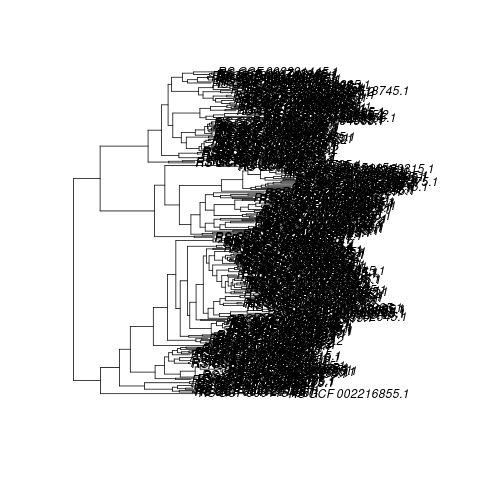

In [19]:
%%R 
write.tree(gtdb_tree_subset,"data/supplemental/Enterobacteriales_gtdb_tree_subset.tree")

plot(gtdb_tree_subset)

In [20]:
%%R
outgroup_best_hits <- all_best_hits %>%
	# select(cinful_id) %>%
	separate(cinful_id, c("family_name",NA,NA,"ID"), sep = "/", remove = FALSE) %>% 
	mutate(family_name = str_replace_all(family_name, "_gtdb","")) %>%
	filter(family_name %in% c("Pasteurellaceae","Vibrionaceae")) #%>%
	# count(ID)
outgroup_best_hits

# A tibble: 204 × 27
   qseqid        sseqid pident length mismatch gapopen qstart  qend sstart  send
   <chr>         <chr>   <dbl>  <dbl>    <dbl>   <dbl>  <dbl> <dbl>  <dbl> <dbl>
 1 v1_PLS_1aaf1… L_tr_…   41.7     24       14       0     14    37     70    93
 2 v1_PLS_b887f… S_tr_…   29.3     58       39       1     43   100     27    82
 3 v1_PLS_3424e… M_tr_…   36.1     36       23       0     10    45      7    42
 4 v1_PLS_5bef9… S_tr_…   25.9     58       41       1     43   100     27    82
 5 v1_PLS_97839… E492_…   36.7     30       17       2      9    36     61    90
 6 v1_PLS_ed997… N_tr_…   37.5     24       15       0     30    53      5    28
 7 v1_PLS_22e4e… S_tr_…   29.3     58       39       1     43   100     27    82
 8 v1_PLS_1cf1b… I47_t…   43.5     23       13       0     15    37      1    23
 9 v1_PLS_9835f… S_tr_…   25.9     58       41       1     43   100     27    82
10 v1_PLS_712c5… S_tr_…   60       15        6       0      1    15      4    18
# … wit

In [21]:
%%R 
other_family_best_hits <- all_best_hits %>%
	# select(cinful_id) %>%
	separate(cinful_id, c("f1","f2","family_name",NA,NA,"ID"), sep = "/", remove =FALSE) %>%
	filter(f1 == "Enterobacteriaceae_gtdb") %>%
	filter(f2 == "other_families") %>%
	select(-f1,-f2)
	# count(family_name)
other_family_best_hits

# A tibble: 221 × 27
   qseqid        sseqid pident length mismatch gapopen qstart  qend sstart  send
   <chr>         <chr>   <dbl>  <dbl>    <dbl>   <dbl>  <dbl> <dbl>  <dbl> <dbl>
 1 v1_PLS_27c29… L_tr_…   55.3     47       21       0      1    47      1    47
 2 v1_PLS_6758c… V_sp_…   40.6     32       19       0      1    32      1    32
 3 v1_PLS_e0e0c… PDI_t…   35.2     88       48       3      1    81      4    89
 4 v1_PLS_7e97d… N_tr_…   46.4     28       13       1      1    28      1    26
 5 v1_PLS_18198… S_tr_…   27.8     97       59       5      1    95      4    91
 6 v1_PLS_4147c… PDI_t…   61.1     18        7       0      3    20      4    21
 7 v1_PLS_ce310… S_tr_…   40.9     44       22       1     18    61     49    88
 8 v1_PLS_c3700… N_tr_…   35.7     42       27       0     27    68      2    43
 9 v1_PLS_ddb67… S_tr_…   34.5    116       66       4      1   106      4   119
10 v1_PLS_37fda… PDI_t…   69.6     23        7       0      2    24      4    26
# … wit

In [22]:
%%R 

Enterobacteriales_best_hits <- other_family_best_hits %>%
	full_join(outgroup_best_hits)
	

Joining, by = c("qseqid", "sseqid", "pident", "length", "mismatch", "gapopen",
"qstart", "qend", "sstart", "send", "evalue", "bitscore", "component",
"hmmerHit", "verified", "cinful_id", "family_name", "ID", "pephash", "sample",
"contig", "start", "stop", "strand", "allStandardAA", "seq", "signalMatch")


In [23]:
%%R
Enterobacteriales_best_hits_microcin <- Enterobacteriales_best_hits %>%
	filter(component == "microcins.verified")

Enterobacteriales_best_hits_microcin

# A tibble: 109 × 27
   qseqid        sseqid pident length mismatch gapopen qstart  qend sstart  send
   <chr>         <chr>   <dbl>  <dbl>    <dbl>   <dbl>  <dbl> <dbl>  <dbl> <dbl>
 1 v1_PLS_27c29… L_tr_…   55.3     47       21       0      1    47      1    47
 2 v1_PLS_6758c… V_sp_…   40.6     32       19       0      1    32      1    32
 3 v1_PLS_e0e0c… PDI_t…   35.2     88       48       3      1    81      4    89
 4 v1_PLS_7e97d… N_tr_…   46.4     28       13       1      1    28      1    26
 5 v1_PLS_18198… S_tr_…   27.8     97       59       5      1    95      4    91
 6 v1_PLS_4147c… PDI_t…   61.1     18        7       0      3    20      4    21
 7 v1_PLS_ce310… S_tr_…   40.9     44       22       1     18    61     49    88
 8 v1_PLS_c3700… N_tr_…   35.7     42       27       0     27    68      2    43
 9 v1_PLS_ddb67… S_tr_…   34.5    116       66       4      1   106      4   119
10 v1_PLS_37fda… PDI_t…   69.6     23        7       0      2    24      4    26
# … wit

In [24]:
%%R
Enterobacteriales_best_hits_microcin_hmmer <- Enterobacteriales_best_hits %>%
	filter(component == "microcins.verified") %>%
	filter(hmmerHit == TRUE)

Enterobacteriales_best_hits_microcin_hmmer

# A tibble: 47 × 27
   qseqid        sseqid pident length mismatch gapopen qstart  qend sstart  send
   <chr>         <chr>   <dbl>  <dbl>    <dbl>   <dbl>  <dbl> <dbl>  <dbl> <dbl>
 1 v1_PLS_27c29… L_tr_…   55.3     47       21       0      1    47      1    47
 2 v1_PLS_6758c… V_sp_…   40.6     32       19       0      1    32      1    32
 3 v1_PLS_e0e0c… PDI_t…   35.2     88       48       3      1    81      4    89
 4 v1_PLS_7e97d… N_tr_…   46.4     28       13       1      1    28      1    26
 5 v1_PLS_ddb67… S_tr_…   34.5    116       66       4      1   106      4   119
 6 v1_PLS_37fda… PDI_t…   69.6     23        7       0      2    24      4    26
 7 v1_PLS_5f70c… N_tr_…   61.0     41       15       1      2    41      1    41
 8 v1_PLS_016a0… L_tr_…   32.3     62       32       2      1    62      1    52
 9 v1_PLS_11ec8… V_sp_…   48.4     31       15       1      1    31      1    30
10 v1_PLS_96351… PDI_t…   54.3     35       16       0      1    35      4    38
# … with

In [25]:
%%R
assemblies_sp_ID_microcin <- assemblies_sp_ID %>%
	mutate(has_micrcocin = ID %in% Enterobacteriales_best_hits_microcin$ID)
assemblies_sp_ID_microcin

# A tibble: 296 × 15
   ID          specific_epithet `NCBI Taxonomy` `GTDB Taxonomy` `GTDB species …`
   <chr>       <chr>            <chr>           <chr>           <chr>           
 1 GCF_000026… Erwinia_tasmani… d__Bacteria; p… d__Bacteria; p… yes             
 2 GCF_000026… Erwinia_pyrifol… d__Bacteria; p… d__Bacteria; p… yes             
 3 GCF_000156… Providencia_rus… d__Bacteria; p… d__Bacteria; p… yes             
 4 GCF_000160… Proteus_mirabil… d__Bacteria; p… d__Bacteria; p… yes             
 5 GCF_000165… Vibrio_caribbea… d__Bacteria; p… d__Bacteria; p… yes             
 6 GCF_000173… Providencia_alc… d__Bacteria; p… d__Bacteria; p… yes             
 7 GCF_000173… Yersinia_aldovae d__Bacteria; p… d__Bacteria; p… yes             
 8 GCF_000173… Yersinia_rohdei  d__Bacteria; p… d__Bacteria; p… yes             
 9 GCF_000175… Actinobacillus_… d__Bacteria; p… d__Bacteria; p… yes             
10 GCF_000176… Vibrio_corallii… d__Bacteria; p… d__Bacteria; p… yes             
# … wit

In [26]:
%%R
assemblies_sp_ID_microcin_hmmer <- assemblies_sp_ID %>%
	mutate(has_micrcocin = ID %in% Enterobacteriales_best_hits_microcin_hmmer$ID)
assemblies_sp_ID_microcin_hmmer

# A tibble: 296 × 15
   ID          specific_epithet `NCBI Taxonomy` `GTDB Taxonomy` `GTDB species …`
   <chr>       <chr>            <chr>           <chr>           <chr>           
 1 GCF_000026… Erwinia_tasmani… d__Bacteria; p… d__Bacteria; p… yes             
 2 GCF_000026… Erwinia_pyrifol… d__Bacteria; p… d__Bacteria; p… yes             
 3 GCF_000156… Providencia_rus… d__Bacteria; p… d__Bacteria; p… yes             
 4 GCF_000160… Proteus_mirabil… d__Bacteria; p… d__Bacteria; p… yes             
 5 GCF_000165… Vibrio_caribbea… d__Bacteria; p… d__Bacteria; p… yes             
 6 GCF_000173… Providencia_alc… d__Bacteria; p… d__Bacteria; p… yes             
 7 GCF_000173… Yersinia_aldovae d__Bacteria; p… d__Bacteria; p… yes             
 8 GCF_000173… Yersinia_rohdei  d__Bacteria; p… d__Bacteria; p… yes             
 9 GCF_000175… Actinobacillus_… d__Bacteria; p… d__Bacteria; p… yes             
10 GCF_000176… Vibrio_corallii… d__Bacteria; p… d__Bacteria; p… yes             
# … wit

In [27]:
%%R 
assemblies_sp_ID_microcin %>%
	count(family_name, has_micrcocin)

# A tibble: 15 × 3
   family_name       has_micrcocin     n
   <chr>             <lgl>         <int>
 1 Budviciaceae      TRUE              3
 2 Erwiniaceae       FALSE            11
 3 Erwiniaceae       TRUE              9
 4 Hafniaceae        FALSE             6
 5 Hafniaceae        TRUE              2
 6 Morganellaceae    FALSE            11
 7 Morganellaceae    TRUE              4
 8 Pasteurellaceae   FALSE            56
 9 Pasteurellaceae   TRUE             12
10 Pectobacteriaceae FALSE            11
11 Pectobacteriaceae TRUE              1
12 Vibrionaceae      FALSE           117
13 Vibrionaceae      TRUE             26
14 Yersiniaceae      FALSE             4
15 Yersiniaceae      TRUE             23


In [28]:
%%R 
assemblies_sp_treeID_microcin <- assemblies_sp_ID_microcin %>%
	filter(has_micrcocin == TRUE) %>%
	left_join(gtdb_tree_ID)
assemblies_sp_treeID_nonmicrocin <- assemblies_sp_ID_microcin %>%
	filter(has_micrcocin == FALSE) %>%
	left_join(gtdb_tree_ID)

Joining, by = "ID"
Joining, by = "ID"


In [29]:
%%R 
assemblies_sp_treeID_microcin_hmmer <- assemblies_sp_ID_microcin_hmmer %>%
	filter(has_micrcocin == TRUE) %>%
	left_join(gtdb_tree_ID)
assemblies_sp_treeID_nonmicrocin_hmmer <- assemblies_sp_ID_microcin_hmmer %>%
	filter(has_micrcocin == FALSE) %>%
	left_join(gtdb_tree_ID)

Joining, by = "ID"
Joining, by = "ID"


In [30]:
%%R

gtdb_tree_subset_microcin_labeled <- groupOTU(gtdb_tree_subset, .node=assemblies_sp_treeID_microcin$value, group_name="has_microcin")
gtdb_tree_subset_nonmicrocin_labeled <- groupOTU(gtdb_tree_subset, .node=assemblies_sp_treeID_nonmicrocin$value, group_name="has_no_microcin")

In [31]:
%%R

gtdb_tree_subset_microcin_hmmer_labeled <- groupOTU(gtdb_tree_subset, .node=assemblies_sp_treeID_microcin_hmmer$value, group_name="has_microcin")
gtdb_tree_subset_nonmicrocin_hmmer_labeled <- groupOTU(gtdb_tree_subset, .node=assemblies_sp_treeID_nonmicrocin_hmmer$value, group_name="has_no_microcin")

In [32]:
%%R 
gtdb_tree_ID_all_info <- gtdb_tree_ID %>%
	full_join(assemblies_sp_ID_microcin)

Joining, by = "ID"


In [33]:
%%R 
gtdb_tree_ID_all_info_hmmer <- gtdb_tree_ID %>%
	full_join(assemblies_sp_ID_microcin_hmmer)

Joining, by = "ID"


In [34]:
%%R 
gtdb_tree_subset_microcin_labeled_specific_epithet <- rename_taxa(gtdb_tree_subset_microcin_labeled, gtdb_tree_ID_all_info, value, specific_epithet)
gtdb_tree_subset_nonmicrocin_labeled_specific_epithet <- rename_taxa(gtdb_tree_subset_nonmicrocin_labeled, gtdb_tree_ID_all_info, value, specific_epithet)

In [35]:
%%R 
gtdb_tree_subset_microcin_hmmer_labeled_specific_epithet <- rename_taxa(gtdb_tree_subset_microcin_hmmer_labeled, gtdb_tree_ID_all_info_hmmer, value, specific_epithet)
gtdb_tree_subset_nonmicrocin_hmmer_labeled_specific_epithet <- rename_taxa(gtdb_tree_subset_nonmicrocin_hmmer_labeled, gtdb_tree_ID_all_info_hmmer, value, specific_epithet)

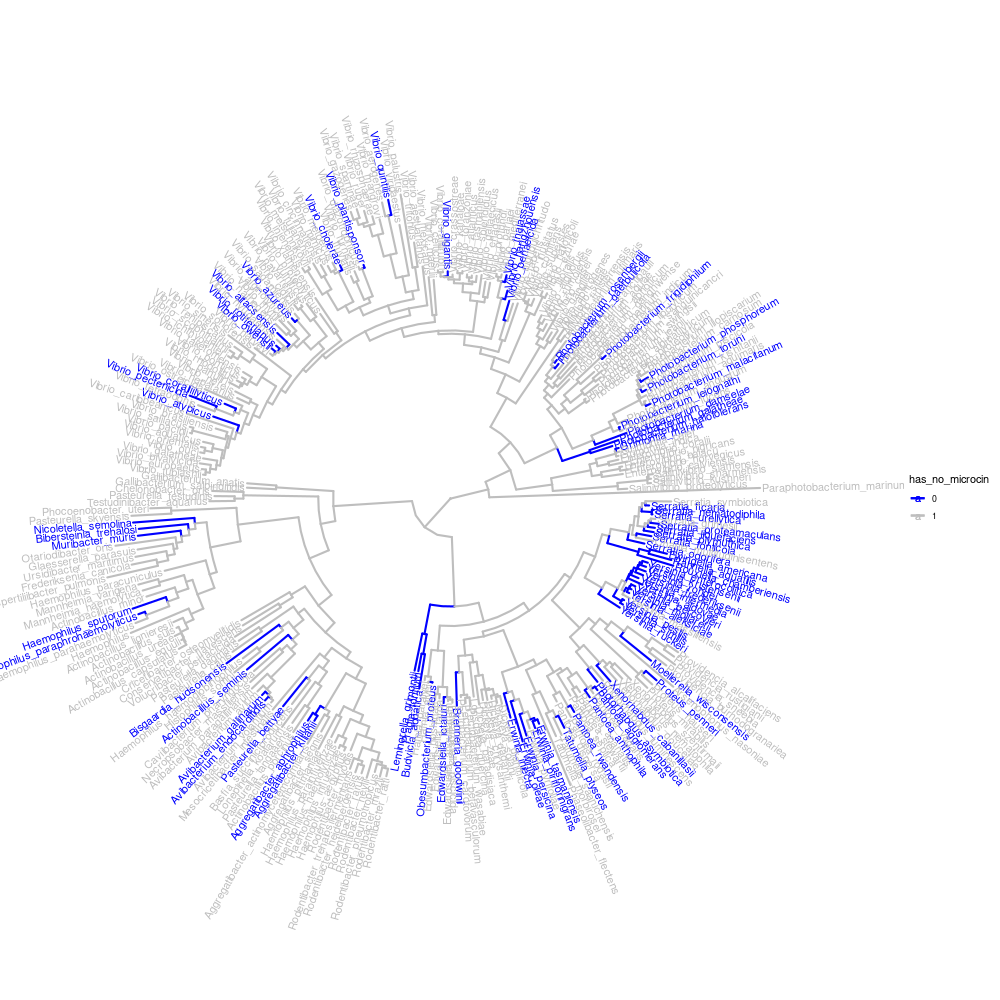

In [36]:
%%R -w 1000 -h 1000
gtdb_tree_subset_nonmicrocin_labeled_specific_epithet %>%
	ggtree(layout="circular", 
			aes(color=has_no_microcin),
			size=1
			) +
		geom_tiplab() +
		scale_color_manual(values=c("blue","gray"))



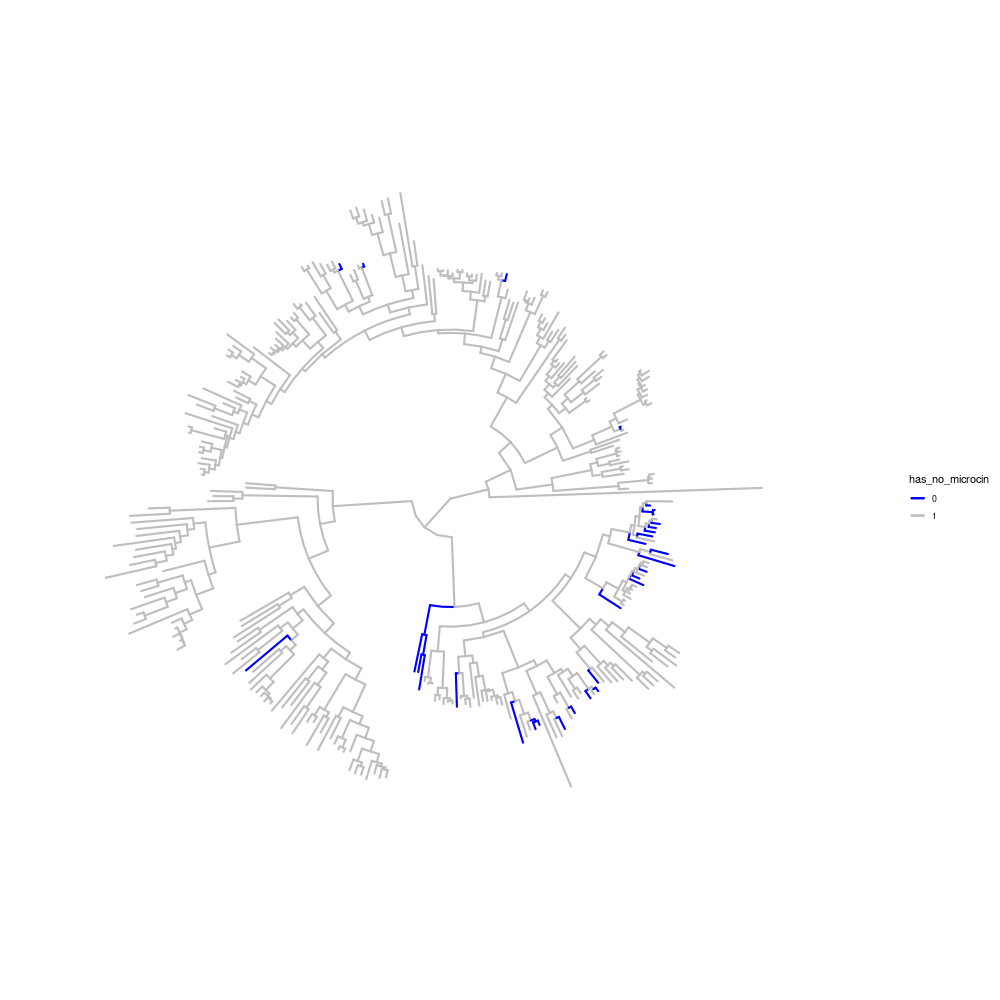

In [37]:
%%R -w 1000 -h 1000

gtdb_tree_subset_nonmicrocin_hmmer_labeled_specific_epithet %>%
	ggtree(layout="circular", 
			aes(color=has_no_microcin),
			size=1
			) +
#		geom_tiplab() +
		scale_color_manual(values=c("blue","gray"))

#ggsave("plots/06_Enterobacteriales_microcin_phylogeny_NO_LABS.svg")